In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [2]:
uuid_unique_count_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['uuid'].nunique().reset_index(name='Unique Container Id')

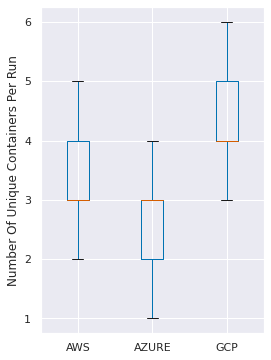

data 
          Unique Container Id                                             
                       count      mean       std  min  25%  50%  75%  max
provider                                                                 
AWS                  28927.0  3.239050  0.657055  1.0  3.0  3.0  4.0  5.0
AZURE                25935.0  2.522961  0.679154  1.0  2.0  3.0  3.0  4.0
GCP                  29006.0  4.177515  0.906849  1.0  4.0  4.0  5.0  6.0


In [3]:
fig, axes = plt.subplots(figsize=(4,6), ncols=1, nrows=1, frameon=False, sharex=True)

bxdf = uuid_unique_count_df[['provider', 'Unique Container Id']].groupby(['provider'], observed=True)
utils.boxplot(axes, bxdf, "Number Of Unique Containers Per Run", utils.tick_get_1st)
utils.plot('pa_instances_unique_containers_per_run', data=bxdf.describe())

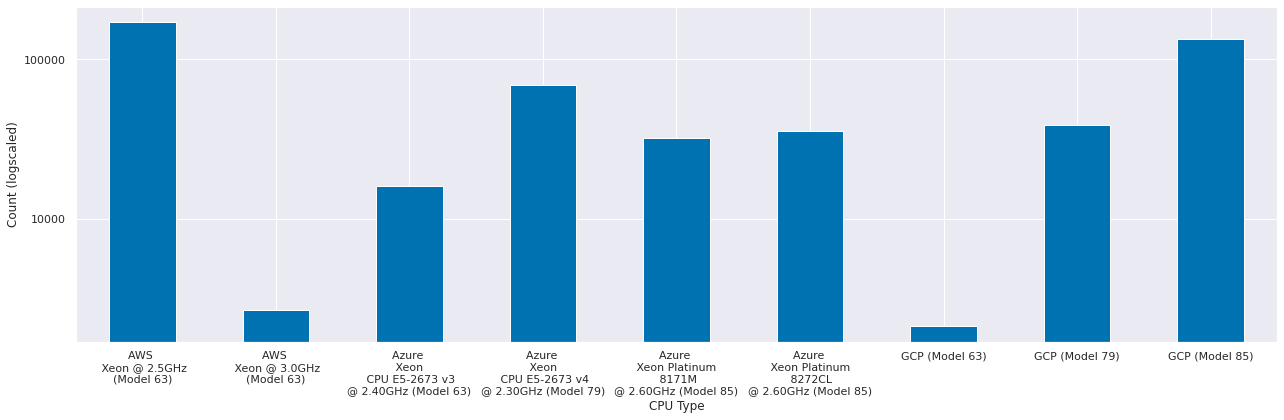

data 
                                                                       workload_invocation
provider cpuModel cpuType                                                                
AWS      63       Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63                  170863
                  Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63                    2703
AZURE    63       Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Mod...                16145
         79       Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Mod...                68510
         85       Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz -...                31893
                  Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz ...                35414
GCP      63       unknown - Model 63                                                 2124
         79       unknown - Model 79                                                38765
         85       unknown - Model 85                                               133119


In [67]:
from matplotlib.ticker import ScalarFormatter

cpudf = df[['provider', 'cpuModel', 'cpuType', 'workload_invocation']]
cpu_counts = cpudf.groupby(['provider', 'cpuModel','cpuType'], observed=True)

fig, axes = plt.subplots(figsize=(18,6))
cpu_counts.count().plot(ax=axes, kind='bar')

cpu_type_rewrite = {
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63)": "AWS \n Xeon @ 2.5GHz\n(Model 63)",
    "(AWS, 63, Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63)" : "AWS \n Xeon @ 3.0GHz\n(Model 63)",
    "(AZURE, 63, Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63)" : "Azure \n Xeon \n CPU E5-2673 v3\n@ 2.40GHz (Model 63)",
    "(AZURE, 79, Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79)" : "Azure \n Xeon \n CPU E5-2673 v4\n@ 2.30GHz (Model 79)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8171M\n@ 2.60GHz (Model 85)",
    "(AZURE, 85, Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85)" : "Azure \n Xeon Platinum \n 8272CL\n@ 2.60GHz (Model 85)",
    "(GCP, 63, unknown - Model 63)" : "GCP (Model 63)",
    "(GCP, 79, unknown - Model 79)" : "GCP (Model 79)",
    "(GCP, 85, unknown - Model 85)" : "GCP (Model 85)",
}

labels = []
for tick in axes.get_xticklabels():
    if tick.get_text() in cpu_type_rewrite.keys():
        labels.append(cpu_type_rewrite[tick.get_text()])
    else:
        labels.append(tick.get_text())
    
axes.set_xlabel('CPU Type')      
axes.set_ylabel('Count (logscaled)')
axes.set_xticklabels(labels)
plt.setp(axes.get_xticklabels(), rotation=0)
axes.get_legend().remove()
axes.set_yscale('log')
axes.yaxis.set_major_formatter(ScalarFormatter())

fig.tight_layout()
utils.plot('pa_instances_cputype', data=cpu_counts.count())